In [1]:
%load_ext autoreload
%autoreload 2
import glob
import sys
from os import path 
from comet_ml import API
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
sys.path.append("..")
sb.set_theme()
from src import config

In [2]:
path_to_test = "test_report"
task_hue_order = ("SSIM", "MOTION", "BINARY")
api = API(config.COMET_API_KEY)

In [16]:
def ridge_plot(df, x, y):
    sb.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    pal = sb.cubehelix_palette(10, rot=-0.25, light=0.7)
    g = sb.FacetGrid(df, row=y, hue=y, aspect=10, height=1, palette=pal)

    # Draw the densities in a few steps
    g.map(
        sb.kdeplot, x, bw_adjust=0.75, clip_on=False, fill=True, alpha=1, linewidth=1.5
    )
    g.map(sb.kdeplot, x, clip_on=False, color="w", lw=2, bw_adjust=0.75)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            fontweight="bold",
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
        )

    g.map(label, x)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    sb.set_theme()


def retrieve_thresholds(unbalanced=False):
    mrart_results = []
    directory = (
        path.join(path_to_test, "unbalanced", "pretrain", "*")
        if unbalanced
        else path.join(path_to_test, "pretraining", "*")
    )
    for models_directory in glob.glob(directory):
        model, task, run = path.basename(models_directory).split("-")

        mrart = pd.read_csv(
            path.join(
                models_directory,
                "unbalanced-mrart_recap.csv" if unbalanced else "mrart_recap.csv",
            )
        )
        mrart["model"] = model
        mrart["task"] = task
        mrart["run_num"] = run

        mrart_results.append(
            mrart[
                [
                    "model",
                    "task",
                    "run_num",
                    "balanced_accuracy",
                    "threshold_1",
                    "threshold_2",
                    "f1_0",
                    "f1_1",
                    "f1_2",
                ]
            ]
        )

    return (
        pd.concat(mrart_results)
        .sort_values(["model", "task"], ascending=False)
        .reset_index(drop=True)
    )


def retrieve_pretrain():
    motion_res = []
    ssim_res = []
    binary_res = []

    for models_directory in glob.glob(path.join(path_to_test, "pretraining", "*")):
        model, task, *_ = path.basename(models_directory).split("-")

        results = pd.read_csv(path.join(models_directory, "results.csv"))
        results["model"] = model
        results["task"] = task
        if task == "MOTION":
            motion_res.append(results[["model", "task", "source", "r2", "rmse"]])
        elif task == "SSIM":
            ssim_res.append(results[["model", "task", "source", "r2", "rmse"]])
        elif task == "BINARY":
            binary_res.append(
                results[["model", "task", "source", "balanced_accuracy", "rmse"]]
            )

    motion_res = pd.concat(motion_res)
    ssim_res = pd.concat(ssim_res)
    binary_res = pd.concat(binary_res)
    motion_res = motion_res[motion_res["source"] == "simple"]
    ssim_res = ssim_res[ssim_res["source"] == "simple"]
    binary_res = binary_res[binary_res["source"] == "simple"]

    return motion_res, ssim_res, binary_res


def retrieve_transfer(unbalanced=False):
    full_results = []
    directory = (
        path.join(path_to_test, "unbalanced", "transfer", "*")
        if unbalanced
        else path.join(path_to_test, "transfer", "*")
    )
    for models_directory in glob.glob(directory):
        model, task, run_num = path.basename(models_directory).split("-")

        results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
        results["model"] = model
        results["task"] = task
        results["run_num"] = int(run_num)

        full_results.append(
            results[
                [
                    "model",
                    "task",
                    "run_num",
                    "source",
                    "balanced_accuracy",
                    "f1_0",
                    "f1_1",
                    "f1_2",
                ]
            ]
        )

    full_results = pd.concat(full_results)
    simple_res = full_results[full_results["source"] == "simple"]
    simple_res = simple_res.drop(columns="source")
    return simple_res.sort_values(
        ["model", "task", "run_num"], ascending=False
    ).reset_index(drop=True)


def retrieve_scratch(unbalanced=False):
    full_results = []
    directory = (
        path.join(path_to_test, "unbalanced", "scratch", "*")
        if unbalanced
        else path.join(path_to_test, "scratch", "*")
    )
    for models_directory in glob.glob(directory):
        model, run_num = (
            path.basename(models_directory).removesuffix(".ckpt").split("-")
        )

        results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
        results["model"] = model
        results["run_num"] = int(run_num)

        full_results.append(
            results[
                [
                    "model",
                    "run_num",
                    "source",
                    "balanced_accuracy",
                    "f1_0",
                    "f1_1",
                    "f1_2",
                ]
            ]
        )

    full_results = pd.concat(full_results)
    simple_scratch = full_results[full_results["source"] == "simple"]
    simple_scratch.sort_values("balanced_accuracy", ascending=False)
    return simple_scratch


def compute_norms(df):
    df["balanced_accuracy_minmax"] = (
        df["balanced_accuracy"] - df["balanced_accuracy"].min()
    ) / (df["balanced_accuracy"].max() - df["balanced_accuracy"].min())
    # df['balanced_accuracy_stand'] = (df['balanced_accuracy']-df['balanced_accuracy'].mean())/(df['balanced_accuracy'].std())


def min_max_norm(serie):
    return (serie - serie.min()) / (serie.max() - serie.min())


def ms_to_time(millis: int):
    seconds = millis // 1000
    minutes = seconds // 60
    hours = minutes // 60
    minutes = minutes % 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)


def get_duration_df_pretrain(experiments):
    durations = []
    for exp in experiments:
        ms = exp.get_metadata()["durationMillis"]
        model = exp.get_parameters_summary("model_class")["valueMax"]
        task = exp.get_parameters_summary("task")["valueMax"]
        hours, minutes = ms_to_time(ms)
        durations.append(
            (model, task, hours, minutes, f"{hours}:{str(minutes).zfill(2)}")
        )
    return pd.DataFrame(
        durations, columns=("model", "task", "hours", "minutes", "duration")
    )


def get_compute_usage_df(experiments, task_dependent=False):
    durations = []
    for exp in experiments:
        ms = exp.get_metadata()["durationMillis"]
        model = exp.get_parameters_summary("model")["valueMax"]

        hours, minutes = ms_to_time(ms)
        gpu_memory = (
            float(exp.get_metrics_summary("sys.gpu.0.used_memory")["valueMax"]) / 1e9
        )
        gpu_power_usage = (
            float(exp.get_metrics_summary("sys.gpu.0.power_usage")["valueMax"]) / 1000
        )

        if task_dependent:
            _, _, _, task, _ = exp.name.split("-")
            durations.append(
                (
                    model,
                    task,
                    ms,
                    hours,
                    minutes,
                    f"{hours}:{str(minutes).zfill(2)}",
                    gpu_memory,
                    gpu_power_usage,
                )
            )
        else:
            durations.append(
                (
                    model,
                    ms,
                    hours,
                    minutes,
                    f"{hours}:{str(minutes).zfill(2)}",
                    gpu_memory,
                    gpu_power_usage,
                )
            )

    if task_dependent:
        columns = (
            "model",
            "task",
            "millis",
            "hours",
            "minutes",
            "duration",
            "max_gpu_ram_used",
            "max_gpu_power_usage",
        )
    else:
        columns = (
            "model",
            "millis",
            "hours",
            "minutes",
            "duration",
            "max_gpu_ram_used",
            "max_gpu_power_usage",
        )

    return pd.DataFrame(durations, columns=columns)

# Are synthetic artifacts close to real artifacts

In [22]:
thresh_mrart_results = retrieve_thresholds()
print(
    thresh_mrart_results[["model", "task", "balanced_accuracy"]].to_latex(
        index=False, escape=True, float_format="%.2f"
    )
)

\begin{tabular}{llr}
\toprule
model & task & balanced\_accuracy \\
\midrule
VIT & SSIM & 0.47 \\
VIT & MOTION & 0.56 \\
VIT & BINARY & 0.52 \\
SFCN & SSIM & 0.68 \\
SFCN & MOTION & 0.67 \\
SFCN & BINARY & 0.33 \\
SERES & SSIM & 0.57 \\
SERES & MOTION & 0.59 \\
SERES & BINARY & 0.35 \\
RES & SSIM & 0.59 \\
RES & MOTION & 0.60 \\
RES & BINARY & 0.25 \\
CONV5\_FC3 & SSIM & 0.59 \\
CONV5\_FC3 & MOTION & 0.61 \\
CONV5\_FC3 & BINARY & 0.52 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_128141/1385608810.py:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sb.boxplot(pred_mrart, x="pred", hue="label", dodge=True, palette=sb.color_palette())


<Axes: xlabel='pred'>

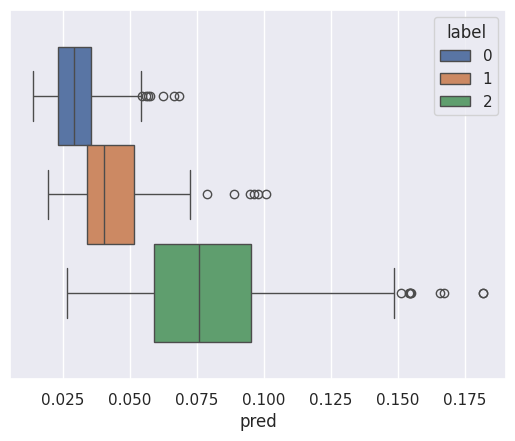

In [46]:
best_row = thresh_mrart_results.sort_values("balanced_accuracy", ascending=False).iloc[
    0
]
best_model = path.join(
    path_to_test,
    "pretraining",
    f"{best_row['model']}-{best_row['task']}-{best_row['run_num']}",
    "mrart.csv",
)
pred_mrart = pd.read_csv(best_model)
sb.boxplot(pred_mrart, x="pred", hue="label", dodge=True, palette=sb.color_palette())

# What metric should we use to pretrain on synthetic artifacts ?

In [4]:
selector = ["task", "balanced_accuracy"]
thresh_df = retrieve_thresholds()
thresh_df = thresh_df[selector].groupby(["task"], as_index=False).median()
compute_norms(thresh_df)
thresh_df["origin"] = "threshold"

transfer_df = retrieve_transfer()
mean_transfer_df = (
    transfer_df[["model", "task", "run_num", "balanced_accuracy"]]
    .groupby(["model", "task"], as_index=False)
    .median()
    .drop(columns="run_num")
)
mean_transfer_df = (
    mean_transfer_df.drop(columns="model").groupby(["task"], as_index=False).median()
)
compute_norms(mean_transfer_df)
mean_transfer_df["origin"] = "transfer"


task_df = pd.concat([mean_transfer_df, thresh_df]).reset_index(drop=True)

In [10]:
mean_tasks = pd.concat([mean_transfer_df, thresh_df])
df = mean_tasks.drop(columns="origin").groupby("task", as_index=False).mean()
df["origin"] = "Mean"

full_res = pd.concat([mean_tasks, df])
full_res = full_res.set_index(["origin", "task"], drop=True, append=False)
full_res
# print(full_res.to_latex(index=True, escape=True, float_format="%.3f", multirow=True))

balanced_accuracy  balanced_accuracy_minmax
origin    task                                               
transfer  BINARY           0.599217                  0.000000
          MOTION           0.682454                  1.000000
          SSIM             0.612208                  0.156072
threshold BINARY           0.347443                  0.000000
          MOTION           0.596722                  1.000000
          SSIM             0.585667                  0.955651
Mean      BINARY           0.473330                  0.000000
          MOTION           0.639588                  1.000000
          SSIM             0.598937                  0.555862

# What model is the best fit for motion prediction task

In [7]:
selector = ["model", "balanced_accuracy"]

transfer_df = retrieve_transfer()[selector + ["task"]]
transfer_df = transfer_df.groupby(["model", "task"], as_index=False).mean()[selector]
transfer_df = transfer_df.groupby(["model"], as_index=False).median()[selector]
transfer_df["setting"] = "Transfer"
compute_norms(transfer_df)

scratch_df = retrieve_scratch()[selector]
scratch_df = scratch_df.groupby(["model"], as_index=False).median()[selector]
scratch_df["setting"] = "Scratch"
compute_norms(scratch_df)


model_df = pd.concat([thresh_df, transfer_df, scratch_df])
report_models = model_df.set_index(["setting", "model"], drop=True, append=False)
report_models
print(
    scratch_df.set_index("model", drop=True).to_latex(
        index=True, escape=True, float_format="%.4f", multirow=True
    )
)

\begin{tabular}{lrlr}
\toprule
 & balanced\_accuracy & setting & balanced\_accuracy\_minmax \\
model &  &  &  \\
\midrule
CONV5\_FC3 & 0.6063 & Scratch & 0.0000 \\
RES & 0.6709 & Scratch & 0.3759 \\
SERES & 0.7421 & Scratch & 0.7906 \\
SFCN & 0.7781 & Scratch & 1.0000 \\
VIT & 0.7513 & Scratch & 0.8442 \\
\bottomrule
\end{tabular}



<Axes: xlabel='model', ylabel='balanced_accuracy'>

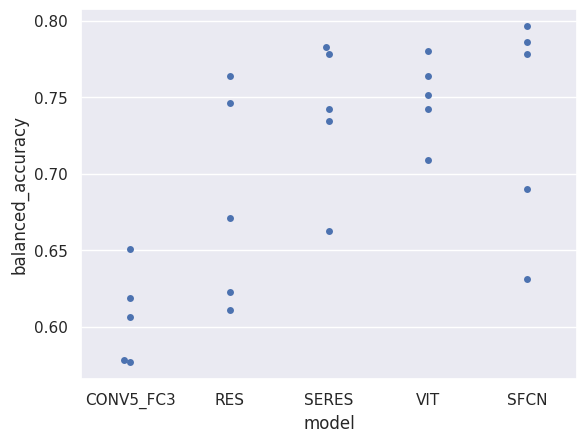

In [9]:
sb.swarmplot(retrieve_scratch()[selector], y="balanced_accuracy", x="model")

In [14]:
model_perf_df = model_df.drop(columns="setting").groupby("model").median()
model_perf_df
# print(
#     model_perf_df.to_latex(index=True, escape=True, float_format="%.4f", multirow=True)
# )

,balanced_accuracy,balanced_accuracy_minmax
model,,
CONV5_FC3,0.606315,0.453879
RES,0.670882,0.448237
SERES,0.622549,0.368770
SFCN,0.692347,1.000000
VIT,0.563668,0.000000


# Should we consider using pretraining ?

## Setting Comparison

\begin{tabular}{lr}
\toprule
setting & balanced\_accuracy \\
\midrule
Scratch & 0.7421 \\
Transfer & 0.6651 \\
\bottomrule
\end{tabular}



,id,setting,model,task,balanced_accuracy
1,Transfer - CONV5_FC3 - MOTION,Transfer,CONV5_FC3,MOTION,0.656085
2,Transfer - CONV5_FC3 - SSIM,Transfer,CONV5_FC3,SSIM,0.674022
4,Transfer - RES - MOTION,Transfer,RES,MOTION,0.742117
5,Transfer - RES - SSIM,Transfer,RES,SSIM,0.692347
7,Transfer - SERES - MOTION,Transfer,SERES,MOTION,0.682454
8,Transfer - SERES - SSIM,Transfer,SERES,SSIM,0.612208
11,Transfer - SFCN - MOTION,Transfer,SFCN,MOTION,0.691960
12,Transfer - SFCN - SSIM,Transfer,SFCN,SSIM,0.590829
14,Transfer - VIT - MOTION,Transfer,VIT,MOTION,0.540586
15,Transfer - VIT - SSIM,Transfer,VIT,SSIM,0.584290


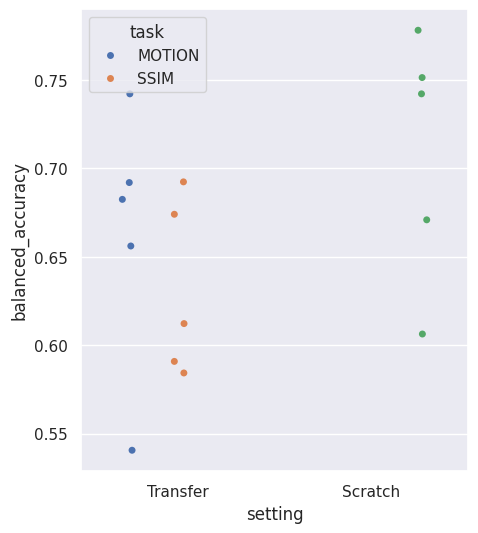

In [14]:
selector = ["id", "setting", "model", "task", "balanced_accuracy"]

transfer_df = retrieve_transfer()
transfer_df = transfer_df.groupby(["model", "task"], as_index=False).median()
transfer_df["setting"] = "Transfer"
transfer_df["id"] = "Transfer - " + transfer_df["model"] + " - " + transfer_df["task"]
transfer_df = transfer_df[
    (transfer_df["task"] == "SSIM") | (transfer_df["task"] == "MOTION")
]

scratch_df = retrieve_scratch().drop(columns=["source"])
scratch_df = scratch_df.groupby(["model"], as_index=False).median()
scratch_df["setting"] = "Scratch"
scratch_df["task"] = ""
scratch_df["id"] = "Scratch - " + scratch_df["model"]

full_res = pd.concat([transfer_df[selector], scratch_df[selector]])
setting_mean = (
    full_res.drop(columns=["id", "model", "task"])
    .groupby("setting", as_index=False)
    .median()
)
print(setting_mean.to_latex(index=False, escape=True, float_format="%.4f"))

plt.figure(figsize=(5, 6))
sb.stripplot(full_res, y="balanced_accuracy", x="setting", hue="task", dodge=True)
full_res

\begin{tabular}{lr}
\toprule
id & balanced\_accuracy \\
\midrule
Transfer - SFCN - MOTION & 0.6920 \\
Scratch - SFCN & 0.7781 \\
\bottomrule
\end{tabular}



Text(0.5, 1.0, 'Balanced accuracy of SFCN model on different setting')

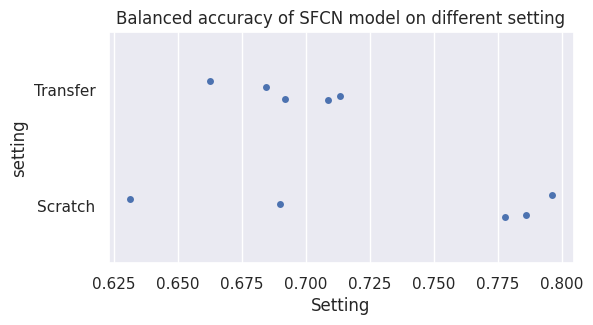

In [24]:
select_res = full_res[full_res["model"] == "SFCN"]
select_res = select_res[(select_res["task"] == "MOTION") | (select_res["task"] == "")]
print(
    select_res[["id", "balanced_accuracy"]].to_latex(
        index=False, escape=True, float_format="%.4f"
    )
)


selector = ["id", "setting", "model", "task", "balanced_accuracy"]

transfer_df = retrieve_transfer()
transfer_df = transfer_df[
    (transfer_df["task"] == "MOTION") & (transfer_df["model"] == "SFCN")
]
transfer_df["setting"] = "Transfer"

scratch_df = retrieve_scratch().drop(columns=["source"])
scratch_df = scratch_df[scratch_df["model"] == "SFCN"]
scratch_df["setting"] = "Scratch"
scratch_df["task"] = ""

sfcn_motion = pd.concat([transfer_df, scratch_df])
plt.figure(figsize=(6, 3))
sb.stripplot(sfcn_motion, y="setting", x="balanced_accuracy")
plt.xlabel("Setting")
plt.title("Balanced accuracy of SFCN model on different setting")

## Power Consumption Comparison

In [8]:
exps = api.get_experiments("mrart", "baseline-mrart")
scratch_ressources_df = get_compute_usage_df(exps)
scratch_ressources_df["task"] = ""
scratch_ressources_df["origin"] = "Scratch"

exps = api.get_experiments("mrart", "estimate-motion-pretrain", "transfer-MRART*")
transfer_ressources_df = get_compute_usage_df(exps, task_dependent=True)
transfer_ressources_df["origin"] = "Transfer"

ValueError: too many values to unpack (expected 2)

In [8]:
%autoreload 2
from src.dataset.mrart.mrart_dataset import TrainMrArt
from src.transforms.load import FinetuneTransform
from src.utils.metrics import separation_capacity_train
import src.utils.task as task_utils
import src.training.eval as teval
from torch.utils.data import DataLoader
import timeit
import os
os.chdir("..")

def eval_thresh(cuda):
    module, task =task_utils.load_pretrain_from_ckpt(ckpt_path="models/pretrained/SFCN-MOTION-3.ckpt")
    dl = DataLoader(TrainMrArt.from_env(FinetuneTransform()))
    train=teval.get_pred_from_pretrain(module, dl, "train", cuda=cuda)
    x_train = train["pred"].to_numpy()
    y_train = train["label"].to_numpy()
    thresholds, _ = separation_capacity_train(
        X=x_train, y=y_train
    )

res_cpu =timeit.timeit(lambda: eval_thresh(False), number=1)
res_cuda =timeit.timeit(lambda: eval_thresh(True), number=1)

os.chdir("notebooks")
res_cpu, res_cuda

SFCN-MOTION-3.ckpt


/home/at70870/Desktop/mrart/notebooks/../src/utils/task.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)
100%|██████████| 258/258 [02:

SFCN-MOTION-3.ckpt


/home/at70870/Desktop/mrart/notebooks/../src/utils/task.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)
100%|██████████| 258/258 [00:

(226.6991955889971, 102.8093471180182)

In [34]:
conv = lambda ms: ":".join(map(lambda x: str(int(x)).zfill(2), ms_to_time(ms)))
time_cpu = conv(res_cpu * 1000)
time_cuda = conv(res_cuda * 1000)
time_cpu, time_cuda

('00:03:46', '00:01:42')

In [95]:
resources = pd.concat([scratch_ressources_df, transfer_ressources_df]).reset_index(
    drop=True
)
resources = (
    resources[["origin", "millis", "max_gpu_ram_used", "max_gpu_power_usage"]]
    .groupby(["origin"])
    .agg(["mean", "std"])
)

resources.loc["Reduced by (%)"] = (
    (resources.loc["Transfer"] - resources.loc["Scratch"])
    .div(resources.loc["Scratch"])
    .mul(100)
)

resources["duration", "mean"] = resources["millis", "mean"].apply(conv)
resources["duration", "std"] = resources["millis", "std"].apply(conv)
resources.loc["Reduced by (%)", "duration"] = resources.loc[
    "Reduced by (%)", "millis"
].to_list()
resources = resources.drop(columns="millis")

print(resources.to_latex(index=True, escape=True, float_format="%.2f"))

\begin{tabular}{lrrrrll}
\toprule
 & \multicolumn{2}{r}{max\_gpu\_ram\_used} & \multicolumn{2}{r}{max\_gpu\_power\_usage} & \multicolumn{2}{r}{duration} \\
 & mean & std & mean & std & mean & std \\
origin &  &  &  &  &  &  \\
\midrule
Scratch & 22.22 & 10.17 & 344.03 & 46.11 & 00:55:33 & 00:27:56 \\
Transfer & 1.59 & 0.53 & 64.50 & 17.98 & 00:18:38 & 00:07:04 \\
Reduced by (\%) & -92.85 & -94.81 & -81.25 & -61.02 & -66.45 & -74.69 \\
\bottomrule
\end{tabular}



## Unbalanced Dataset Comparison

\begin{tabular}{lr}
\toprule
setting & balanced\_accuracy \\
\midrule
Scratch & 0.4483 \\
Threshold & 0.5476 \\
\bottomrule
\end{tabular}



<Axes: xlabel='balanced_accuracy', ylabel='setting'>

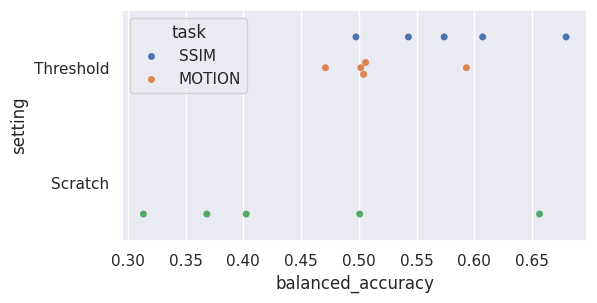

In [22]:
selector = ["id", "setting", "model", "task", "balanced_accuracy"]
thresh_df = retrieve_thresholds(unbalanced=True)
thresh_df["setting"] = "Threshold"
thresh_df["id"] = "Threshold - " + thresh_df["model"] + " - " + thresh_df["task"]
thresh_df = thresh_df[thresh_df["task"] != "BINARY"]

# transfer_df = retrieve_transfer(unbalanced=True)
# transfer_df = transfer_df.groupby(["model", "task"], as_index=False).mean()
# transfer_df["setting"] = "Transfer"
# transfer_df["id"] = "Transfer - " + transfer_df["model"] + " - " + transfer_df["task"]

scratch_df = retrieve_scratch(unbalanced=True).drop(columns=["source"])
scratch_df = scratch_df.groupby(["model"], as_index=False).mean()
scratch_df["setting"] = "Scratch"
scratch_df["task"] = ""
scratch_df["id"] = "Scratch - " + scratch_df["model"]

# full_res = pd.concat([thresh_df[selector], transfer_df[selector], scratch_df[selector]])
full_res = pd.concat([thresh_df[selector], scratch_df[selector]])
setting_mean = (
    full_res.drop(columns=["id", "model", "task"])
    .groupby("setting", as_index=False)
    .mean()
)
print(setting_mean.to_latex(index=False, escape=True, float_format="%.4f"))

plt.figure(figsize=(6, 3))
sb.swarmplot(full_res, x="balanced_accuracy", y="setting", hue="task", dodge=True)

\begin{tabular}{lr}
\toprule
id & balanced\_accuracy \\
\midrule
Threshold - SFCN - MOTION & 0.5866 \\
Transfer - SFCN - MOTION & 0.4017 \\
Scratch - SFCN & 0.4082 \\
\bottomrule
\end{tabular}



Text(0.5, 1.0, 'Balanced accuracy of SFCN model on different setting')

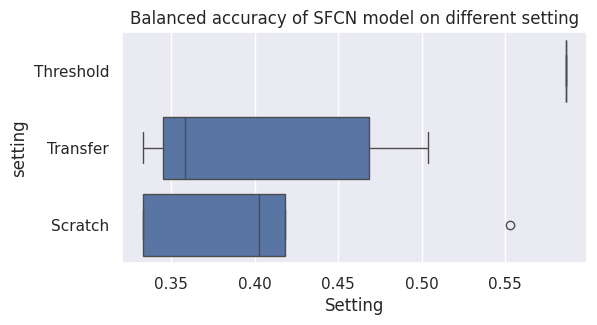

In [65]:
select_res = full_res[full_res["model"] == "SFCN"]
select_res = select_res[(select_res["task"] == "MOTION") | (select_res["task"] == "")]
print(
    select_res[["id", "balanced_accuracy"]].to_latex(
        index=False, escape=True, float_format="%.4f"
    )
)


selector = ["id", "setting", "model", "task", "balanced_accuracy"]
thresh_df = retrieve_thresholds(unbalanced=True)
thresh_df = thresh_df[(thresh_df["task"] == "MOTION") & (thresh_df["model"] == "SFCN")]
thresh_df["setting"] = "Threshold"

transfer_df = retrieve_transfer(unbalanced=True)
transfer_df = transfer_df[
    (transfer_df["task"] == "MOTION") & (transfer_df["model"] == "SFCN")
]
transfer_df["setting"] = "Transfer"

scratch_df = retrieve_scratch(unbalanced=True).drop(columns=["source"])
scratch_df = scratch_df[scratch_df["model"] == "SFCN"]
scratch_df["setting"] = "Scratch"
scratch_df["task"] = ""

sfcn_motion = pd.concat([thresh_df, transfer_df, scratch_df])
plt.figure(figsize=(6, 3))
sb.boxplot(sfcn_motion, y="setting", x="balanced_accuracy")
plt.xlabel("Setting")
plt.title("Balanced accuracy of SFCN model on different setting")

##  Accuracy Conservation

In [28]:
def get_full(unbalanced):
    selector = ["setting", "model", "task", "balanced_accuracy"]
    thresh_df = retrieve_thresholds(unbalanced=unbalanced)
    thresh_df["setting"] = "Threshold"
    thresh_df = thresh_df[thresh_df["task"] != "BINARY"]

    # transfer_df = retrieve_transfer(unbalanced=unbalanced)
    # transfer_df = transfer_df.groupby(["model", "task"], as_index=False).mean()
    # transfer_df["setting"] = "Transfer"

    scratch_df = retrieve_scratch(unbalanced=unbalanced).drop(columns=["source"])
    scratch_df = scratch_df.groupby(["model"], as_index=False).mean()
    scratch_df["setting"] = "Scratch"
    scratch_df["task"] = ""

    # return pd.concat(
    #     [thresh_df[selector], transfer_df[selector], scratch_df[selector]]
    # ).set_index(["setting", "model", "task"])
    return pd.concat([thresh_df[selector], scratch_df[selector]]).set_index(
        ["setting", "model", "task"]
    )


normal_df = get_full(False)
unbalanced_df = get_full(True)
loss = unbalanced_df.sub(normal_df)
normal_df["balanced_accuracy_unb"] = unbalanced_df["balanced_accuracy"]
normal_df["accuracy_loss"] = loss
normal_df["percent_loss"] = (
    normal_df["accuracy_loss"].div(normal_df["balanced_accuracy"]) * 100
)
acc_conv = (
    normal_df.reset_index().drop(columns=["model", "task"]).groupby("setting").mean()
)

print(acc_conv.to_latex(index=True, escape=True, float_format="%.2f"))
acc_conv

\begin{tabular}{lrrrr}
\toprule
 & balanced\_accuracy & balanced\_accuracy\_unb & accuracy\_loss & percent\_loss \\
setting &  &  &  &  \\
\midrule
Scratch & 0.70 & 0.45 & -0.25 & -36.46 \\
Threshold & 0.58 & 0.55 & -0.04 & -7.03 \\
\bottomrule
\end{tabular}



,balanced_accuracy,balanced_accuracy_unb,accuracy_loss,percent_loss
setting,,,,
Scratch,0.702895,0.448304,-0.254591,-36.456357
Threshold,0.576493,0.547637,-0.044229,-7.025109


# How to determine if a pretrained model will behave well based on pretrain metrics

In [11]:
motion, ssim, binary = retrieve_pretrain()

thresh_df = retrieve_thresholds()
transfer_df = retrieve_transfer()

motion['metric'] = 